In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import json
from itertools import zip_longest
import os
from math import sqrt
import holidays

# instance_varibles
# GLOBAL_VARIABLES

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [3]:
print(os.getcwd())

c:\Users\user\veritas


In [4]:
with open("../veritas_data/parser_menus/menu.json", "r") as f:
    MENU = json.load(f)

In [81]:
def load_ts_data(file_name):
    print("Loading main columns...")
    df = pd.read_csv(file_name, usecols=["device_id", "date", "store_id", "class", "total_price"], header=0)

    print("Formatting main columns...")
    df["device_id"], device_map = df["device_id"].factorize()
    df["store_id"], store_map = df["store_id"].factorize()
    df["class"], class_map = df["class"].factorize()
    df = df.astype("uint32")

    print("Loading products...")
    with open(file_name, "r") as f:
        num_columns = len(f.readline().split(","))
    for cols in zip_longest(*(iter(range(5, num_columns)),) * 50):
        cols = [c for c in cols if c is not None]
        temp_df = pd.read_csv(file_name, usecols=list(cols), header=0, dtype="uint8")
        temp_df = temp_df.loc[:, (temp_df != 0).any(axis=0)]   # Remove "zero" columns 
        df = pd.concat([df, temp_df], axis=1)

    wl = [col for col in df.columns if col not in ['device_id', 'store_id', 'class', "date"]]
    df = df.drop(df[df[wl].eq(0).all(axis=1)].index)
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.index = df["date"]
    df = df.drop(["date"], axis=1)
    return df, device_map, store_map, class_map

In [82]:
TS_FILE = "../veritas_data/post_parser_orders/device_time_series.csv"
TSF, DEVICE_MAP, STORE_MAP, CLASS_MAP = load_ts_data(TS_FILE)

Loading main columns...
Formatting main columns...
Loading products...


In [83]:
# Returns the device_id, number of orders and the data frame of the device with the most orders
def get_top_devices(device_id_list, ts_frame, n):
    top_devices = []
    for device_id in device_id_list:
        df = ts_frame.loc[ts_frame["device_id"] == device_id, ["store_id"]]
        try:
            store_id = df.values[0][0]
        except:
            continue
        num_orders = len(df.index)
        top_devices.append((device_id, num_orders, store_id))
        top_devices = sorted(top_devices, key=lambda d: d[1], reverse=True)[:n]
    return top_devices

# Returns df without rows where col_name equals a value occuring less than threshold times
def trim_low_occurance_values(df, col_name, threshold):
    s = df[col_name].value_counts().ge(threshold)
    return df[df[col_name].isin(s[s].index)]

In [84]:
DEVICES = get_top_devices(range(len(DEVICE_MAP)), trim_low_occurance_values(TSF, "device_id", 1000), 10)
print(DEVICE_MAP[DEVICES[0][0]], DEVICES[0][0], DEVICES[0][1])

AwwOCgoACwwKCgYEBAoIDg 435 30266


In [85]:
COL_WL = [col for col in TSF.columns if col not in ['device_id', 'store_id', 'class']]

In [86]:
def get_top_cols(df, row_index, n_cols):
    if len(df) == 0:
        return []
    row_frame = df.iloc[row_index].copy()
    columns = []
    for _ in range(n_cols):
        if len(row_frame) == 0:
            break
        col_id = row_frame.idxmax()
        columns.append(col_id)
        row_frame = row_frame.drop([col_id])
    return columns

In [87]:
def get_color_dict(labels):
    #labels = [col for col in df.columns if col not in ["device_id", "date", "store_id", "class", "total_price"]]
    colors = [cm.rainbow(i) for i in np.linspace(0, 1, len(labels))]
    c_dict = {}
    for i, label in enumerate(labels):
        c_dict[label] = colors[i]
    return c_dict

In [36]:
START_INDEX = 0
N_COLS = 6
COL_SET = set()
for D in DEVICES:
    DEVICE_FRAME = TSF.loc[TSF["device_id"] == D[0], COL_WL].copy()
    DEVICE_FRAME = DEVICE_FRAME.drop(["total_price"], axis=1)
    DEVICE_FRAME = DEVICE_FRAME.resample("H").sum().iloc[START_INDEX:]
    DEVICE_FRAME = DEVICE_FRAME.cumsum()
    for C in get_top_cols(DEVICE_FRAME, -1, N_COLS):
        COL_SET.add(C)
COLOR_DICT = get_color_dict(COL_SET)

In [ ]:
for D in DEVICES:
    DEVICE_FRAME = TSF.loc[TSF["device_id"] == D[0], column_whitelist].copy()
    if len(DEVICE_FRAME) == 0:
        continue
    DEVICE_FRAME = DEVICE_FRAME.drop(["total_price"], axis=1)
    DEVICE_FRAME = DEVICE_FRAME.resample("H").sum().iloc[START_INDEX:]
    DEVICE_FRAME = DEVICE_FRAME.cumsum()
    COLS = get_top_cols(DEVICE_FRAME, -1, N_COLS)
    fig = plt.figure()
    DEVICE_FRAME.plot(kind='line',y=COLS, figsize=(16, 10), color=[COLOR_DICT.get(x, '#666666') for x in COLS], linewidth=3.0)
    plt.legend(prop={'size': 18})
    plt.figtext(.5,.9, "Device "+str(D[0])+", Store "+str(D[2]),fontsize=24)
    #plt.show()
    plt.savefig("C:/Users/user/Desktop/store_/"+str(D[2]+"/"+"device_"+str(D[0])+"_day.png")
    plt.close(fig)

In [88]:
def add_time_cols(df):
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["day_of_month"] = df.index.day
    df["month"] = df.index.month
    holidays_swe = holidays.Sweden(include_sundays=False)[df.index[0]: df.index[-1]]
    df["holiday"] = [1 if d in holidays_swe else 0 for d in df.index.date]

def remove_zero_sequence(df, col, min_length):
    mask = col.groupby((col != col.shift()).cumsum()).transform('count').lt(min_length)
    mask = ~(mask | col.gt(0))
    df.drop(mask[mask].index, axis=0, inplace=True)

In [125]:
def get_test_train_split(df, train_len=pd.Timedelta(4, unit='W'), forecast_len=pd.Timedelta(1, unit='W'), expanding_window=False):
    start = df.index.values[0]
    split = df.index.values[0] + train_len
    forecast_end = split + forecast_len
    end = df.index.values[-1]
    sets = []
    while end > forecast_end:
        sets.append((df[start:split].index, df[split:forecast_end].index))
        if not expanding_window:
            start += train_len + forecast_len
        split += train_len + forecast_len
        forecast_end = split + forecast_len
    return sets

DEVICE_FRAME = TSF.loc[TSF["device_id"] == DEVICES[0][0], COL_WL].copy()
len(get_test_train_split(DEVICE_FRAME))

16

In [133]:
from statsmodels.tsa.vector_ar.var_model import VAR

def train_and_predict_var(train_set, n_steps):
    model = VAR(endog=train)
    model_fit = model.fit()
    prediction = model_fit.forecast(model_fit.y, steps=n_steps)
    return prediction

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

def validate(predictions, true_val):
    sum_meanAE = mean_absolute_error(predictions, true_val).sum()
    sum_medianAE = median_absolute_error(predictions, true_val).sum()
    return sum_meanAE, sum_medianAE

In [135]:
DEVICE_FRAME = TSF.loc[TSF["device_id"] == DEVICES[0][0], COL_WL].copy()
#DEVICE_FRAME["orders"] = 1
AGG_DICT = {col_name:np.sum for col_name in DEVICE_FRAME.columns}
AGG_DICT.update({"total_price":np.mean})
DEVICE_FRAME = DEVICE_FRAME.resample("H").agg(AGG_DICT).fillna(0).cumsum()
DEVICE_FRAME.rename(columns={'total_price': 'average_price'}, inplace=True)
DEVICE_FRAME.drop(["average_price"], axis=1, inplace=True)
#remove_zero_sequence(DEVICE_FRAME, DEVICE_FRAME.orders, 25)
#add_time_cols(DEVICE_FRAME)

In [140]:
test_train = get_test_train_split(DEVICE_FRAME)
pred = train_and_predict_var(DEVICE_FRAME.loc[test_train[0][0]], len(test_train[0][1]))
print(pred.shape, DEVICE_FRAME.loc[test_train[0][1]].shape, DEVICE_FRAME.loc[test_train[0][0]].shape)
validate(pred, DEVICE_FRAME.loc[test_train[0][1]])

(169, 215) (169, 254) (673, 254)


ValueError: y_true and y_pred have different number of output (215!=254)

plt.scatter(DEVICE_FRAME.index, DEVICE_FRAME["orders"].cumsum())
plt.figure(figsize=(20,100))

In [109]:
TRAIN_PERCENT = 0.8
TRAIN_SIZE = -336#int(len(DEVICE_FRAME)*TRAIN_PERCENT)
TRAIN_Y = DEVICE_FRAME[:TRAIN_SIZE]
TRAIN_Y = TRAIN_Y.loc[:, (TRAIN_Y != TRAIN_Y.iloc[0]).any()]
VAL_Y = DEVICE_FRAME[TRAIN_Y.columns][TRAIN_SIZE:]
#TRAIN_X = DEVICE_FRAME["day"]
#VAL_X = DEVICE_FRAME["day"]

In [110]:
#creating the train and validation set
train = TRAIN_Y
valid = VAL_Y
naive_pred = DEVICE_FRAME[TRAIN_SIZE-1:-1]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [111]:
#converting predictions to dataframe
pred = pd.DataFrame(index=valid.index,columns=VAL_Y.columns)
for j in range(0,len(VAL_Y.columns)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

In [114]:
#check rmse
print("MAE VAR, MAE Naive, Min Val, Max Val")
MIN = valid.min()
MAX = valid.max()
SUM_MAE = 0
for i in pred.columns:
    SUM_MAE += mean_absolute_error(pred[i], valid[i])
    print('MAE value for', str(i)+':\t', mean_absolute_error(pred[i], valid[i]), "\t", mean_absolute_error(naive_pred[i], valid[i]), "\t", MIN[i], "\t", MAX[i])
print("AVG MAE:", (SUM_MAE/len(VAL_Y.columns)))

MAE VAR, MAE Naive, Min Val, Max Val
MAE value for product_4:	 9.046415686240934 	 0.03869047619047619 	 227 	 240
MAE value for product_5:	 18.32007883764724 	 0.005952380952380952 	 177 	 179
MAE value for product_6:	 15.729182753971294 	 0.020833333333333332 	 101 	 108
MAE value for product_7:	 19.913533216607338 	 0.0 	 42 	 42
MAE value for product_8:	 5.410114229526589 	 0.008928571428571428 	 88 	 91
MAE value for product_9:	 3.475980863725818 	 0.03869047619047619 	 272 	 285
MAE value for product_10:	 18.854181166639144 	 0.03571428571428571 	 299 	 311
MAE value for product_11:	 30.30261218695559 	 0.017857142857142856 	 202 	 208
MAE value for product_12:	 30.40986383141287 	 0.15773809523809523 	 1528 	 1581
MAE value for product_14:	 161.48177034575104 	 0.31845238095238093 	 2383 	 2490
MAE value for product_15:	 110.31643171506923 	 0.05654761904761905 	 318 	 337
MAE value for product_16:	 135.37055985773281 	 0.07738095238095238 	 369 	 395
MAE value for product_17:	 

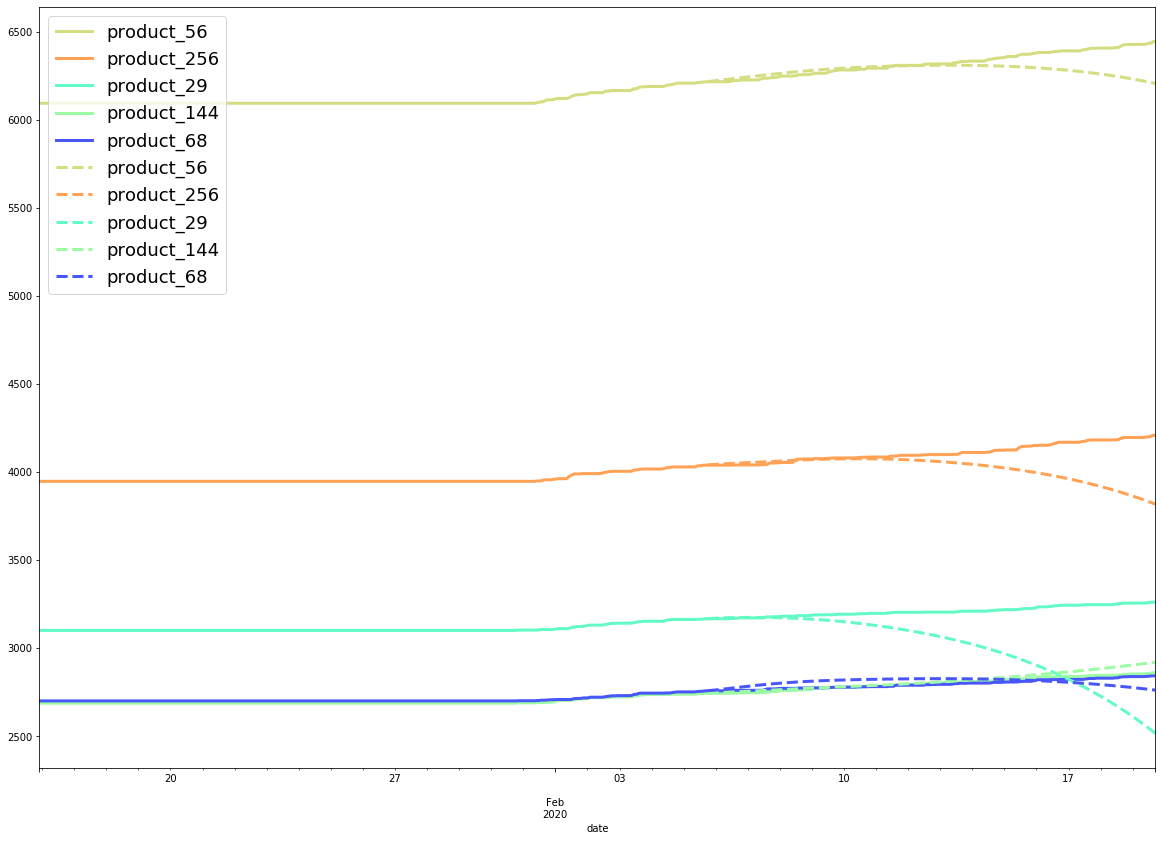

In [115]:
SUM_TRUE = TRAIN_Y.iloc[-500:].append(VAL_Y)
SUM_VAR = pred
COLS = get_top_cols(SUM_TRUE, -1, 5)
COLOR_DICT = get_color_dict(COL_SET)
_, ax = plt.subplots()
SUM_TRUE.plot(ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
SUM_VAR.plot(linestyle='dashed', ax=ax, kind='line',y=COLS, figsize=(20, 14), color=[COLOR_DICT.get(x, '#FFFFFF') for x in COLS], linewidth=3.0)
plt.legend(prop={'size': 18})
plt.show()

#converting predictions to dataframe
pred = pd.DataFrame(index=valid.index,columns=DEVICE_FRAME.columns)
for j in range(0,len(DEVICE_FRAME.columns)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
print("RMSE for VAR predictions and Naive Predictions")
for i in DEVICE_FRAME.columns:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])), "\t", sqrt(mean_squared_error(naive_pred[i], valid[i])))

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

DEVICE_FRAME = sc.fit_transform(DEVICE_FRAME)
DEVICE_FRAME.min()